# Project P3 - Feminism in movies

### Import the movies and put into the dataframe

In [48]:
from helpers import *
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
 
file_source ='/Users/mariannecivitardevol/Documents/EPFL/Masters/Year 2/ADA copy/'
bechdel_path2 = "/Users/mariannecivitardevol/Documents/EPFL/Masters/Year 2/ADA copy/MovieSummaries/movies_feminism.csv"
MovieMetadata_df, CharacterMetadata_df, names_df, plot_summaries_df, tvTropes_df = create_datasets(file_source)

# Create a dataframe with the bechdel data as well as plots
bechdel_data2 = pd.read_csv(bechdel_path2)
# drop the NaN movie plots
plot_summaries_df = plot_summaries_df.dropna(subset=['Summaries'])
merged_bechdel_plot = bechdel_plots_dataset_creation(bechdel_data2, MovieMetadata_df,plot_summaries_df)

In [4]:
summaries = merged_bechdel_plot['Summaries']
score = merged_bechdel_plot['bt_score']

## 1. Trouver les thèmes dans les déscriptions des films


### Document classification 
Represent each movie summary as a feature of vectors in a TF-IDF matrix.

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

vectorizer = CountVectorizer()
#create bag of words features
X = vectorizer.fit_transform(summaries)

print('Number of samples:',X.toarray().shape[0])
print('Number of features:',X.toarray().shape[1])

#mask and convert to int Frankenstein
Y = np.array(score) == 3
Y = Y.astype(int)  

#shuffle the data
X, Y = shuffle(X, Y, random_state=0)

#Balance the data
rus = RandomUnderSampler(random_state=42)
X, Y = rus.fit_resample(X, Y)

#split into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Number of samples: 3863
Number of features: 46992


In [ ]:
# Train on a logistic regression model
accs = []

#the grid of regularization parameter 
grid = [0.01,0.1,1,10,100,1000,10000]

for c in grid:
    #initialize the classifier
    clf = LogisticRegression(random_state=0, solver='lbfgs',C = c)
    
    #crossvalidate
    scores = cross_val_score(clf, X_train,Y_train, cv=10)
    accs.append(np.mean(scores))

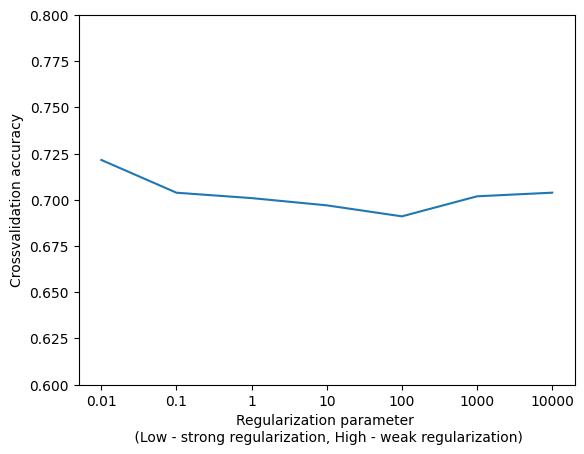

In [7]:
plt.plot(accs)
plt.xticks(range(len(grid)), grid)
plt.xlabel('Regularization parameter \n (Low - strong regularization, High - weak regularization)')
plt.ylabel('Crossvalidation accuracy')
plt.ylim([0.6,0.8])
plt.show()

In [8]:
# Best accuracy :
clf = LogisticRegression(random_state=0, solver='lbfgs',C = 0.01).fit(X_train,Y_train)

#predict on the test set
print('Best acuracy with logistic regression:',clf.score(X_test,Y_test))

Best acuracy with logistic regression: 0.7834645669291339


In [9]:
# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the coefficients of the model
coefficients = clf.coef_[0]

# Combine feature names with their corresponding coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by the absolute value of coefficients (important features)
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

In [10]:
# Separate features contributing to True (positive class) and False (negative class)
positive_features = feature_importance[feature_importance['Coefficient'] > 0].sort_values(by='Coefficient', ascending=False)
negative_features = feature_importance[feature_importance['Coefficient'] < 0].sort_values(by='Coefficient')

# Display top 10 features contributing to True
print("Top 10 features predicting True (class 1):")
print(positive_features.head(10))

# Display top 10 features contributing to False
print("\nTop 10 features predicting False (class 0):")
print(negative_features.head(10))


Top 10 features predicting True (class 1):
        Feature  Coefficient
15096    family     0.127542
19351       her     0.104610
4224     begins     0.090311
37623       she     0.087888
28585       new     0.087445
8689    company     0.085998
46106      with     0.082713
20041     house     0.082183
36742    school     0.080438
7645   children     0.079943

Top 10 features predicting False (class 0):
        Feature  Coefficient
26561       men    -0.117830
19849     honey    -0.116774
42245      time    -0.105134
7806    christy    -0.097281
33730  rapunzel    -0.093046
18873    harold    -0.088076
28914    norman    -0.085587
19568       him    -0.083566
44529   vanessa    -0.080022
17832    gothel    -0.074055


### Topic detection 
Do clustering and find features

In [11]:
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

nlp = spacy.load('en_core_web_sm')

#put in raw text, get a Spacy object
all_docs = []
for summary in summaries :
    doc = nlp(summary)
    all_docs.append(doc)

In [12]:
# preprocess :
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
processed_docs = list()
for doc in all_docs :
    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)

In [13]:
# Add bigrams too
from gensim.models.phrases import Phrases

# Add bigrams to docs (only ones that appear 15 times or more).
bigram = Phrases(processed_docs, min_count=15)

for idx in range(len(processed_docs)):
    for token in bigram[processed_docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            processed_docs[idx].append(token)

processed_docs[0]

['Cinderella',
 'love',
 'child',
 'widow',
 'aristocrat',
 'decide',
 'beloved',
 'daughter',
 'need',
 'mother',
 'care',
 'Cinderella',
 'father',
 'marry',
 'Lady',
 'Tremaine',
 'proud',
 'woman',
 'daughter',
 'marriage',
 'Drizella',
 'Anastasia',
 'plain',
 'socially',
 'awkward',
 'stepsister',
 'bitterly',
 'envious',
 'beautiful',
 'charming',
 'Cinderella',
 'death',
 'Cinderella',
 'father',
 'Lady',
 'Tremaine',
 'daughter',
 'estate',
 'begin',
 'abuse',
 'mistreat',
 'Cinderella',
 'jealousy',
 'allow',
 'cat',
 'Lucifer',
 'torment',
 'despite',
 'force',
 'servitude',
 'home',
 'Cinderella',
 'kind',
 'woman',
 'befriend',
 'animal',
 'live',
 'barn',
 'mouse',
 'bird',
 'live',
 'chateau',
 'royal',
 'palace',
 'King',
 'distress',
 'son',
 'intend',
 'marry',
 'determined',
 'grandchild',
 'King',
 'Duke',
 'organize',
 'ball',
 'Prince',
 'Charming',
 'effort',
 'enable',
 'son',
 'marry',
 'eligible',
 'maiden',
 'kingdom',
 'request',
 'attend',
 'invitation',
 '

In [14]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(processed_docs)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus)) # This is equal to the number of summaries that we have

Number of unique tokens: 12568
Number of chunks: 3863


In [15]:
# models
from gensim.models import LdaMulticore
params = {'passes': 10, 'random_state': 42}
base_models = dict()
model = LdaMulticore(corpus=corpus, num_topics=2, id2word=dictionary, workers=6,
                passes=params['passes'], random_state=params['random_state'])

In [16]:
model.show_topic(1,20)

[('kill', 0.007525232),
 ('tell', 0.0040397486),
 ('escape', 0.0038374276),
 ('man', 0.0037295565),
 ('return', 0.0036296698),
 ('try', 0.0034616266),
 ('attack', 0.0033508127),
 ('reveal', 0.0029674463),
 ('begin', 0.0029287965),
 ('discover', 0.002894005),
 ('attempt', 0.002837546),
 ('arrive', 0.0027307647),
 ('time', 0.002705228),
 ('later', 0.002624651),
 ('order', 0.002602208),
 ('help', 0.0025837072),
 ('meet', 0.0025567487),
 ('film', 0.00236901),
 ('father', 0.0023499804),
 ('force', 0.0023304268)]

In [17]:
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

In [18]:
# try with a training and testing set:
train_docs, test_docs, Y_train, Y_test = train_test_split(processed_docs, score, test_size=0.3, random_state=42)

# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary_train = Dictionary(train_docs)
dictionary_test = Dictionary(test_docs)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary_train.filter_extremes(no_below=min_wordcount, no_above=max_freq)
dictionary_test.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus_train = [dictionary_train.doc2bow(doc) for doc in train_docs]
corpus_test = [dictionary_test.doc2bow(doc) for doc in test_docs]

#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens train: %d' % len(dictionary_train))
print('Number of chunks tran: %d' % len(corpus_train)) 


print('Number of unique tokens test: %d' % len(dictionary_test))
print('Number of chunks test: %d' % len(corpus_test)) 

Number of unique tokens train: 10220
Number of chunks tran: 2704
Number of unique tokens test: 6205
Number of chunks test: 1159


In [19]:
from gensim.models import LdaMulticore
params = {'passes': 10, 'random_state': 42}
base_models = dict()
model2 = LdaMulticore(corpus=corpus_train, num_topics=2, id2word=dictionary_train, workers=6,
                passes=params['passes'], random_state=params['random_state'])

In [20]:
model2.show_topic(0,20)

[('film', 0.0038640515),
 ('return', 0.0037294896),
 ('friend', 0.0035188722),
 ('time', 0.003486674),
 ('life', 0.00341909),
 ('try', 0.0033638077),
 ('man', 0.0033361176),
 ('meet', 0.0032818343),
 ('home', 0.003214111),
 ('love', 0.0032083746),
 ('kill', 0.0031053475),
 ('begin', 0.0030110735),
 ('end', 0.0029625017),
 ('father', 0.0029501908),
 ('family', 0.002818134),
 ('come', 0.002775028),
 ('mother', 0.0027364735),
 ('year', 0.002722369),
 ('later', 0.0027114504),
 ('day', 0.0026794344)]

In [21]:
Y_test.iloc[1]

3

In [22]:
# Predict topics for the test corpus
predicted_topics_test = []

for doc in corpus_test:
    # Get the topic distribution for the document
    topics = model2.get_document_topics(doc, minimum_probability=0.0)
    predicted_topics_test.append(topics)

acc = 0
i = 0
for prediction in predicted_topics_test:
    pred_non_feminist = prediction[1][1]
    pred_feminist = prediction[0][1]
    if (pred_non_feminist < pred_feminist) and Y_test.iloc[i] == 3:
        acc+=1
    i+=1
acc = acc/len(predicted_topics_test)
print('accuracy: ', acc)

accuracy:  0.4719585849870578


## Analyser les résultats

### Predict on all of the movies and create a single dataframe

In [59]:
# Add movie names to dataframe
movie_ID_names = MovieMetadata_df[['Wikipedia movie ID','Movie name']]
plot_summaries_df_names = pd.merge(movie_ID_names, plot_summaries_df, on='Wikipedia movie ID', how='inner')
plot_summaries_df_names

,Wikipedia movie ID,Movie name,Summaries
0,975900,Ghosts of Mars,"Set in the second half of the 22nd century, th..."
1,9363483,White Of The Eye,A series of murders of rich young women throug...
2,261236,A Woman in Flames,"Eva, an upper class housewife, becomes frustra..."
3,18998739,The Sorcerer's Apprentice,"Every hundred years, the evil Morgana returns..."
4,6631279,Little city,"Adam, a San Francisco-based artist who works a..."
...,...,...,...
42199,23851782,The Ghost Train,{{plot}} The film opens with a Great Western e...
42200,35228177,Mermaids: The Body Found,Two former National Oceanic Atmospheric Admini...
42201,34980460,Knuckle,{{No plot}} This film follows 12 years in the ...
42202,913762,The Super Dimension Fortress Macross II: Lover...,"The story takes place in the year 2092,The Sup..."


In [60]:
merged_bechdel_plot

,Movie name,bt_score,Wikipedia movie ID,Summaries
0,Cinderella,3,399402,Cinderella is the much-loved only child of a w...
1,Cinderella,3,18979350,Cinderella is a winsome young girl who lives w...
2,Cinderella,3,1303197,"In the village square, a Herald proclaims: ""T..."
3,Cinderella,3,11584626,The film starts off with a birthday cake being...
4,Cinderella,3,24016193,"An adaptation of the fairy tale, Cinderella tr..."
...,...,...,...,...
3858,Evolution,0,899255,A meteor crashes into the desert near Glen Can...
3859,The Magnificent Seven,0,31556,A Mexican village is periodically raided for f...
3860,Passengers,0,15053838,Psychotherapist Claire Summers is called upon...
3861,Dunkirk,0,1222552,The film relates the story of Operation Dynamo...


In [61]:
# Predict on all of the movies with the bag of groups

all_summaries = plot_summaries_df_names['Summaries']

dataset_non_predicted = plot_summaries_df_names.copy()

# find the movies that are on both of the datasets --> give them the label
# Predict on the movies that are not on the feminist

movie_ids_feminist_dataset = merged_bechdel_plot['Wikipedia movie ID']
movie_ids_feminist_dataset = np.array(movie_ids_feminist_dataset)

index = 0
for movie_id in dataset_non_predicted['Wikipedia movie ID']:
    if movie_id in movie_ids_feminist_dataset:
        dataset_non_predicted.drop([index])
    index += 1

summaries_non_predicted = dataset_non_predicted['Summaries']

In [62]:
X_non_predicted = vectorizer.transform(summaries_non_predicted)

# Predict class labels for the new data
predictions = clf.predict(X_non_predicted)

In [64]:
#Add new column to dataframe
bool_new_predictions = pd.Series(predictions)
dataset_non_predicted['feminist'] = bool_new_predictions
display(dataset_non_predicted)

#Change columns on bechdel dataset to match the other
merged_bechdel_plot2 = merged_bechdel_plot.copy()
merged_bechdel_plot2.rename(columns = {'bt_score':'feminist'}, inplace = True)
merged_bechdel_plot2['feminist'].loc[merged_bechdel_plot2['feminist'] == 3] = 1
display(merged_bechdel_plot2)

,Wikipedia movie ID,Movie name,Summaries,feminist
0,975900,Ghosts of Mars,"Set in the second half of the 22nd century, th...",1
1,9363483,White Of The Eye,A series of murders of rich young women throug...,1
2,261236,A Woman in Flames,"Eva, an upper class housewife, becomes frustra...",1
3,18998739,The Sorcerer's Apprentice,"Every hundred years, the evil Morgana returns...",1
4,6631279,Little city,"Adam, a San Francisco-based artist who works a...",1
...,...,...,...,...
42199,23851782,The Ghost Train,{{plot}} The film opens with a Great Western e...,0
42200,35228177,Mermaids: The Body Found,Two former National Oceanic Atmospheric Admini...,0
42201,34980460,Knuckle,{{No plot}} This film follows 12 years in the ...,1
42202,913762,The Super Dimension Fortress Macross II: Lover...,"The story takes place in the year 2092,The Sup...",1


/var/folders/v0/fsjhyw8s4q981gycqjlwxknm0000gn/T/ipykernel_13626/2570254350.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  merged_bechdel_plot2['feminist'].loc[merged_bechdel_plot2['feminist'] == 3] = 1
/var/folders/v0/fsjhyw8s4q981gycq

,Movie name,feminist,Wikipedia movie ID,Summaries
0,Cinderella,1,399402,Cinderella is the much-loved only child of a w...
1,Cinderella,1,18979350,Cinderella is a winsome young girl who lives w...
2,Cinderella,1,1303197,"In the village square, a Herald proclaims: ""T..."
3,Cinderella,1,11584626,The film starts off with a birthday cake being...
4,Cinderella,1,24016193,"An adaptation of the fairy tale, Cinderella tr..."
...,...,...,...,...
3858,Evolution,0,899255,A meteor crashes into the desert near Glen Can...
3859,The Magnificent Seven,0,31556,A Mexican village is periodically raided for f...
3860,Passengers,0,15053838,Psychotherapist Claire Summers is called upon...
3861,Dunkirk,0,1222552,The film relates the story of Operation Dynamo...


In [66]:
# Merge both into a single dataframe
all_movies_predicted = pd.concat([merged_bechdel_plot2,dataset_non_predicted], ignore_index=True)
all_movies_predicted

,Movie name,feminist,Wikipedia movie ID,Summaries
0,Cinderella,1,399402,Cinderella is the much-loved only child of a w...
1,Cinderella,1,18979350,Cinderella is a winsome young girl who lives w...
2,Cinderella,1,1303197,"In the village square, a Herald proclaims: ""T..."
3,Cinderella,1,11584626,The film starts off with a birthday cake being...
4,Cinderella,1,24016193,"An adaptation of the fairy tale, Cinderella tr..."
...,...,...,...,...
46062,The Ghost Train,0,23851782,{{plot}} The film opens with a Great Western e...
46063,Mermaids: The Body Found,0,35228177,Two former National Oceanic Atmospheric Admini...
46064,Knuckle,1,34980460,{{No plot}} This film follows 12 years in the ...
46065,The Super Dimension Fortress Macross II: Lover...,1,913762,"The story takes place in the year 2092,The Sup..."


### Actually perform some analysis

([<matplotlib.patches.Wedge at 0x3053fda10>,
 [Text(-0.2672430319035179, 1.0670431865201218, 'Feminist'),
  Text(0.2672431318073102, -1.0670431614990188, 'Non-feminist')],
 [Text(-0.1457689264928279, 0.5820235562837027, '57.8%'),
  Text(0.14576898098580554, -0.5820235426358283, '42.2%')])

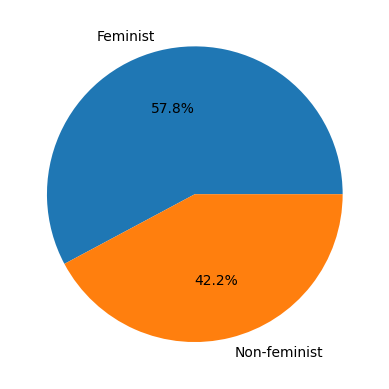

In [76]:
# pie chart of feminist vs non feminist movies
import matplotlib.pyplot as plt

labels = 'Feminist', 'Non-feminist'
counts = all_movies_predicted['feminist'].value_counts()
sizes = [counts[1], counts[0]]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')

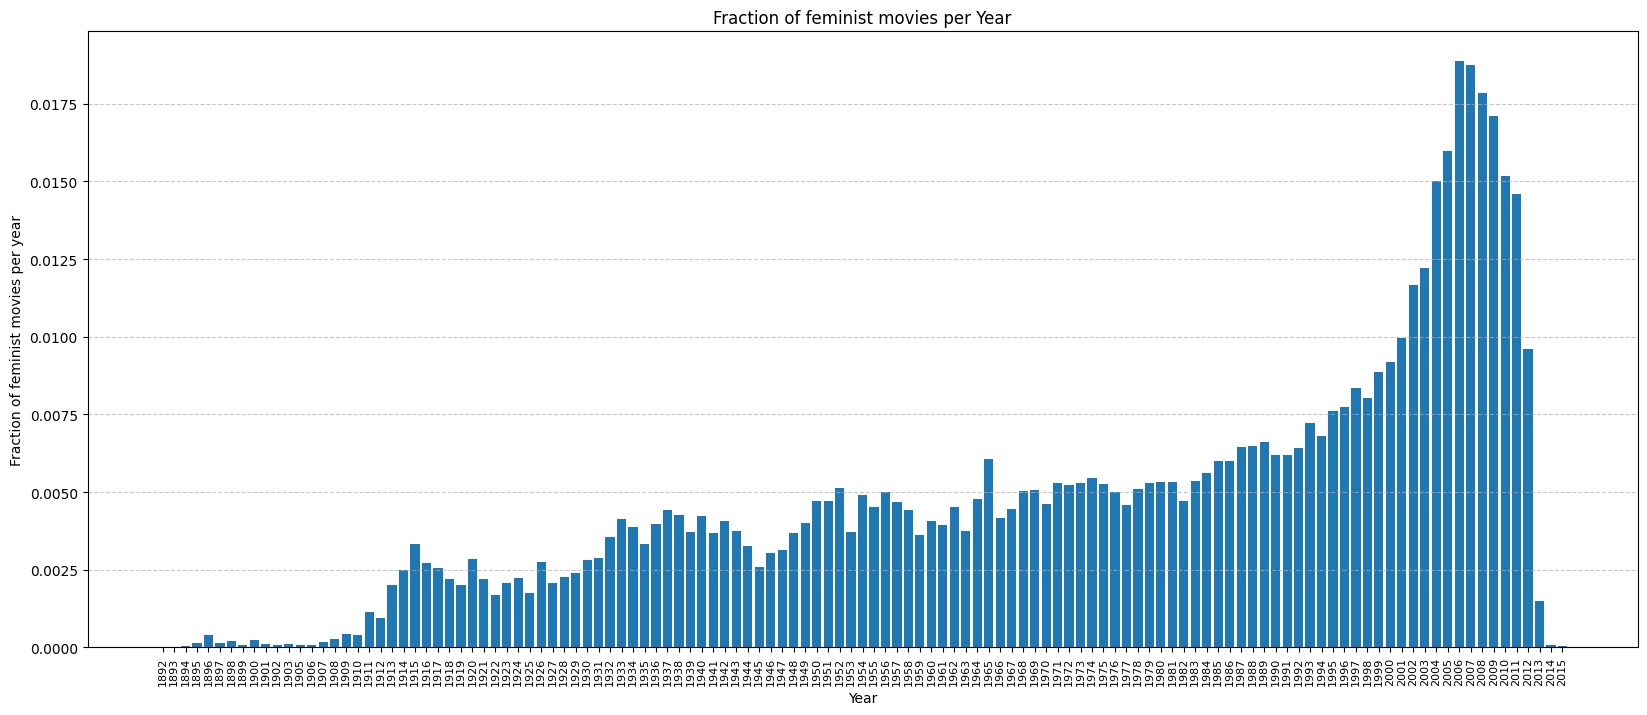

In [88]:
# Analyse by year
# Add the years to the plots:
filtered_years = filter_years(MovieMetadata_df)
all_movies_predicted['year'] = filtered_years

# Count the number of feminist movies per year
feminist_count = all_movies_predicted[all_movies_predicted['feminist'] == 1]
count_per_year = feminist_count.groupby('year').size().reset_index(name='count')

# Plot the fraction of feminist movies per year
plt.figure(figsize=(20, 8)) 
plt.bar(count_per_year['year'], count_per_year['count']/len(all_movies_predicted))
plt.xlabel('Year')
plt.ylabel('Fraction of feminist movies per year')
plt.title('Fraction of feminist movies per Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90, fontsize=8) 
plt.show()